In [ ]:
from __future__ import print_function, division

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import qgrid

import numpy as np
from numpy import diff
import math

import pandas as pd
import xarray as xr

import climlab
from climlab.solar.insolation import daily_insolation
from climlab.radiation import DailyInsolation
from climlab.radiation import FixedInsolation
from climlab.process import TimeDependentProcess
from climlab.utils import heat_capacity
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
from matplotlib.legend import Legend

from IPython.display import HTML


import scipy as scp
from attrdict import AttrDict
from datetime import datetime

import dask.dataframe as dd

import warnings

import util
import ram_model
import plotting

### To do:

create a RAT, RA, RT dataset each, then run through a notebook to look at the results

## Data

Read data and concatenate into one dataset.

level 0 = Surface

level 110 = TOA

(our data is in the order TOA-->Surface)

In [3]:
ds = util.load_soundings()
util.add_monthly_insolation(ds)
ds = util.adjust_lev(ds, nlevels = 95)
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
co2_lev = ds.CO2_list.values

Dropped levels [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 17, 18, 20, 22, 24, 26]


# Climlab

All tendencies must be in K/sec (see Climlab energy_budget documentation and self.heating_rate attribute): https://climlab.readthedocs.io/en/latest/_modules/climlab/process/energy_budget.html#EnergyBudget

In [52]:
timestep = 3600 #seconds

############# FIND OUR AVERAGE KAPPA AND ADVECTION ###############

#### Find the surface diffk average over 12 months at CO2 = .00038 ####
mean_diffk_dict = {}
mean_diffk_dict = ram_model.fill_ensemble(ds, mean_diffk_dict, timestep, 
                                                     advection_on = True, turbulence_on = True, 
                                                     advection = None, 
                                                     surface_diffk = None)
surface_diffk_average = ram_model.annual_mean_sfc_diffk(ds, mean_diffk_dict)
print(surface_diffk_average)

#### Find our initial advection #### 
adv_dict = {}
adv_dict = ram_model.fill_ensemble(ds, adv_dict, timestep, 
                                   advection_on = True, turbulence_on = True, 
                                   advection = None, 
                                   surface_diffk = surface_diffk_average)
advection_380_monthly = {}
for m in months:
    advection_380_monthly[m] = adv_dict[0.00038][m].subprocess.Advection.forcing_tendencies['Tatm']
    
############# CREATE OUR MODELS ############    
#### Use our initial advection and surface diffk to run the model #### 

########### RADIATIVE ADVECTIVE TURBULENT #############
rat_dict = {}
rat_dict = ram_model.fill_ensemble(ds, rat_dict, timestep, 
                                   advection_on = True, turbulence_on = True, 
                                   advection = advection_380_monthly,
                                   surface_diffk = surface_diffk_average)



/Users/lyssafreese/Documents/code/antarctic_rad/notebooks/ram_model.py:115: UserWarning: CFL Condition not met, [1.24807274], timestep too large or lower level z difference too small for January, CO2 kg/kg
  warnings.warn(f"CFL Condition not met, {self._CFL}, timestep too large or lower level z difference too small for {self.m}, CO2 kg/kg")


[0.35573846]


In [53]:
########### RADIATIVE ADVECTIVE #############
ra_dict = {}
ra_dict = ram_model.fill_ensemble(ds, ra_dict, timestep, 
                                   advection_on = True, turbulence_on = False, 
                                   advection = advection_380_monthly,
                                   surface_diffk = surface_diffk_average)



In [54]:
########### RADIATIVE TURBULENT #############
rt_dict = {}
rt_dict = ram_model.fill_ensemble(ds, rt_dict, timestep, 
                                   advection_on = False, turbulence_on = True, 
                                   advection = None,
                                   surface_diffk = surface_diffk_average)

# Output (initial and over time)

In [55]:
month_ds_dict = {} #Empty dictionary to add values into
steps = 20
fields_dict = {'TdotLW_clr':'z', 'LW_flux_up_clr':'z_bounds', 
               'LW_flux_down_clr':'z_bounds', 'LW_flux_net_clr':'z_bounds', 
               'TdotSW_clr':'z', 'SW_flux_up_clr':'z_bounds', 
               'SW_flux_down_clr':'z_bounds', 'SW_flux_net_clr':'z_bounds'}
model_dict = {'rat':rat_dict.copy(),
             'rt':rt_dict.copy(),
             'ra':ra_dict.copy()}

In [58]:
#original
ex_dict = rat_dict.copy()
for month in months:
    month_ds_dict[month] = xr.Dataset(data_vars = {
                                    'model' : ('model', ['rat','rt','ra']),
                                    'co2_lev': ('co2_lev', ds['CO2_list'].values), 
                                    'time': ('time', np.arange(0,((steps+1)*timestep),timestep)),
                                    'lev': ('lev', ex_dict[.00038][month].lev),
                                    'lev_full': ('lev_full', np.append(ex_dict[.00038][month].lev, 
                                                                       ex_dict[.00038][month].lev[-1]+(ex_dict[.00038][month].lev[-1]-ex_dict[.00038][month].lev[-2]))),
                                    'lev_bounds': ('lev_bounds', ex_dict[.00038][month].lev_bounds)
                                    })
    lev_da = xr.DataArray(
                        data = np.zeros((month_ds_dict[month].dims['model'],month_ds_dict[month].dims['co2_lev'],month_ds_dict[month].dims['lev'],month_ds_dict[month].dims['time'])), 
                        coords = ((month_ds_dict[month].coords['model'], month_ds_dict[month].coords['co2_lev'], month_ds_dict[month].coords['lev'], month_ds_dict[month].coords['time'])),
                        dims = ('model','co2_lev', 'lev','time')
                    )


    lev_bounds_da = xr.DataArray(
                        data = np.zeros((month_ds_dict[month].dims['model'], month_ds_dict[month].dims['co2_lev'],month_ds_dict[month].dims['lev_bounds'],month_ds_dict[month].dims['time'])), 
                        coords = ((month_ds_dict[month].coords['model'], month_ds_dict[month].coords['co2_lev'], month_ds_dict[month].coords['lev_bounds'], month_ds_dict[month].coords['time'])),
                        dims = ('model','co2_lev', 'lev_bounds','time')
                    )
    lev_full_da = xr.DataArray(
                        data = np.zeros((month_ds_dict[month].dims['model'], month_ds_dict[month].dims['co2_lev'],month_ds_dict[month].dims['lev_full'],month_ds_dict[month].dims['time'])), 
                        coords = ((month_ds_dict[month].coords['model'], month_ds_dict[month].coords['co2_lev'], month_ds_dict[month].coords['lev_full'], month_ds_dict[month].coords['time'])),
                        dims = ('model','co2_lev', 'lev_full','time')
                    )
    month_ds_dict[month]['T'] = lev_full_da.copy()
    month_ds_dict[month]['turb_hr'] = lev_full_da.copy()
    month_ds_dict[month]['turbulent_flux'] = lev_bounds_da.copy()
    month_ds_dict[month]['diffk'] = lev_bounds_da.copy()
    month_ds_dict[month]['theta_init'] = lev_da.copy()
    month_ds_dict[month]['theta'] = lev_da.copy()
    month_ds_dict[month]['turb_atm_hr'] = lev_da.copy()
    month_ds_dict[month]['advection'] = lev_full_da.copy()
    
    for var in fields_dict.keys():
        if fields_dict[var] == 'z':
            month_ds_dict[month][var] = lev_da.copy()
        if fields_dict[var] == 'z_bounds':
            month_ds_dict[month][var] = lev_bounds_da.copy()
            
    for co2 in ex_dict.keys():
        for dict_name in model_dict.keys():
            #create z coords
            month_ds_dict[month] = month_ds_dict[month].assign_coords(z = model_dict[dict_name][co2][month].z)
            month_ds_dict[month] = month_ds_dict[month].assign_coords(z_bounds = model_dict[dict_name][co2][month].z_bounds)
            month_ds_dict[month] = month_ds_dict[month].assign_coords(z_full = np.append(model_dict[dict_name][co2][month].z, 0))
            
            month_ds_dict[month]['T'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].state['Tatm']),
                                                         np.array(model_dict[dict_name][co2][month].state['Ts']))
            
            if 'a' in dict_name:
                month_ds_dict[month]['advection'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].subprocess.Advection.forcing_tendencies['Tatm']),
                                                         np.array(model_dict[dict_name][co2][month].subprocess.Advection.forcing_tendencies['Ts']))
            
            if 't' in dict_name:
                month_ds_dict[month]['turb_hr'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].diagnostics['turb_atm_hr']),
                                                             np.array(model_dict[dict_name][co2][month].diagnostics['turb_sfc_hr']))
                month_ds_dict[month]['turbulent_flux'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].diagnostics['atm_turbulent_flux']),
                                                             np.array(model_dict[dict_name][co2][month].diagnostics['sfc_turbulent_flux']))
                month_ds_dict[month]['diffk'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].diagnostics['atm_diffk']),
                                                             np.array(model_dict[dict_name][co2][month].diagnostics['surface_diffk']))
                month_ds_dict[month]['theta_init'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = model_dict[dict_name][co2][month].diagnostics['theta_init'].to_xarray().data
                month_ds_dict[month]['theta'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = model_dict[dict_name][co2][month].diagnostics['theta'].to_xarray().data
                month_ds_dict[month]['turb_atm_hr'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = model_dict[dict_name][co2][month].diagnostics['turb_atm_hr'].to_xarray().data

            for var in fields_dict.keys():
                month_ds_dict[month][var].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = model_dict[dict_name][co2][month].diagnostics[var].to_xarray().data


In [59]:
month_ds_dict[month]

<xarray.Dataset>
Dimensions:           (co2_lev: 11, lev: 77, lev_bounds: 78, lev_full: 78, model: 3, time: 21, z: 77, z_bounds: 78, z_full: 78)
Coordinates:
  * model             (model) <U3 'rat' 'rt' 'ra'
  * co2_lev           (co2_lev) float64 0.0 1e-06 5e-06 ... 0.00076 0.001 0.0015
  * time              (time) int64 0 3600 7200 10800 ... 61200 64800 68400 72000
  * lev               (lev) float64 0.5741 1.038 1.853 ... 667.9 677.8 686.5
  * lev_full          (lev_full) float64 0.5741 1.038 1.853 ... 686.5 695.2
  * lev_bounds        (lev_bounds) float64 0.3419 0.8063 1.446 ... 682.1 690.8
  * z                 (z) float64 5.223e+04 4.723e+04 4.223e+04 ... 158.8 52.92
  * z_bounds          (z_bounds) float64 5.473e+04 4.973e+04 ... 105.8 0.0
  * z_full            (z_full) float64 5.223e+04 4.723e+04 ... 52.92 0.0
Data variables:
    T                 (model, co2_lev, lev_full, time) float64 275.4 0.0 ... 0.0
    turb_hr           (model, co2_lev, lev_full, time) float64 -3.586e-22

In [60]:
#timestepper
for month in months:
    for dict_name in model_dict.keys():
        for co2 in rat_dict.keys():
            for i in range(steps):
                #step the model forward
                model_dict[dict_name][co2][month].step_forward()
                #assign temperature
                month_ds_dict[month]['T'].loc[dict(co2_lev = co2, time = ((i+1)*timestep), model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].state['Tatm']),
                                                             np.array(model_dict[dict_name][co2][month].state['Ts']))
                #assign the variables in the 'field dict' which are typical outputs from climlab
                for var in fields_dict.keys():

                    month_ds_dict[month][var].loc[dict(co2_lev = co2, time = ((i+1)*timestep), model = dict_name)] = model_dict[dict_name][co2][month].diagnostics[var].to_xarray().data


                #assign the variables in the 'advection' field
                if 'a' in dict_name:

                    month_ds_dict[month]['advection'].loc[dict(co2_lev = co2, time = ((i+1)*timestep), model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].subprocess.Advection.forcing_tendencies['Tatm']),
                                                             np.array(model_dict[dict_name][co2][month].subprocess.Advection.forcing_tendencies['Ts']))
                #assign the variables in the 'turbulence field'
                if 't' in dict_name:
                   
                    month_ds_dict[month]['turb_hr'].loc[dict(co2_lev = co2, time = ((i+1)*timestep), model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].diagnostics['turb_atm_hr']),
                                                                 np.array(model_dict[dict_name][co2][month].diagnostics['turb_sfc_hr']))
                    month_ds_dict[month]['turbulent_flux'].loc[dict(co2_lev = co2, time = ((i+1)*timestep), model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].diagnostics['atm_turbulent_flux']),
                                                                 np.array(model_dict[dict_name][co2][month].diagnostics['sfc_turbulent_flux']))
                    month_ds_dict[month]['diffk'].loc[dict(co2_lev = co2, time = ((i+1)*timestep), model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].diagnostics['atm_diffk']),
                                                                 np.array(model_dict[dict_name][co2][month].diagnostics['surface_diffk']))
                    month_ds_dict[month]['theta_init'].loc[dict(co2_lev = co2, time = ((i+1)*timestep), model = dict_name)] = model_dict[dict_name][co2][month].diagnostics['theta_init'].to_xarray().data
                    month_ds_dict[month]['theta'].loc[dict(co2_lev = co2, time = ((i+1)*timestep), model = dict_name)] = model_dict[dict_name][co2][month].diagnostics['theta'].to_xarray().data
                    month_ds_dict[month]['turb_atm_hr'].loc[dict(co2_lev = co2, time = ((i+1)*timestep), model = dict_name)] = model_dict[dict_name][co2][month].diagnostics['turb_atm_hr'].to_xarray().data



In [61]:
###create a dict of output names and the z bounds they align with
output_dict = {}
output_dict['bounds'] = {'Tatm':'z','TdotLW_clr':'z', 'LW_flux_up_clr':'z_bounds', 
               'LW_flux_down_clr':'z_bounds', 'LW_flux_net_clr':'z_bounds', 
               'TdotSW_clr':'z', 'SW_flux_up_clr':'z_bounds', 
               'SW_flux_down_clr':'z_bounds', 'SW_flux_net_clr':'z_bounds',
               'theta_init':'z', 'theta':'z', 'dtheta_dz':'z_bounds', 'atm_diffk':'z_bounds', 
               'atm_turbulent_flux':'z_bounds','turb_atm_hr':'z', 
               'turb_hr':'z', 'advection_Tatm':'z'}
atm_process_dict = {'Tatm':'Atmospheric Temperature (K)',
                    'atm_diffk':r'Atmospheric $\kappa$ ($\frac{m^2}{s}$)',
                    'dtheta_dz':r'$\frac{d\theta}{dz}$ ($\frac{K}{m}$)',
                    'theta':r'$\theta$',
                    'SW_flux_net_clr':r'Shortwave Flux ($\frac{W}{m^2}$)',
                    'LW_flux_net_clr':r'Longwave Flux ($\frac{W}{m^2}$)', 
                    'TdotLW_clr':r'Longwave Heating Rate ($\frac{K}{s}$)',
                    'TdotSW_clr':r'Shortwave Heating Rate ($\frac{K}{s}$)',
                    'turb_atm_hr':r'Turbulent Heating Rate ($\frac{K}{s}$)',
                    'advection_Tatm':r'Advective Heating Rate ($\frac{K}{s}$)',
                   'atm_turbulent_flux':'Turbulent Flux'}
single_level_process = {'LW_sfc_clr':r'Surface Longwave Flux ($\frac{W}{m^2}$)', 
                        'Ts': 'Surface Temperature (K)', 
                        'ASRclr':r'Absorbed Solar Radiation, ($\frac{W}{m^2}$)', 
                        'SW_sfc_clr':r'Surface Shortwave Flux ($\frac{W}{m^2}$)', 
                        'total_sfc_flux':r'Total Surface Flux ($\frac{W}{m^2}$)', 
                        'dtheta_dz_near_surf_init':r'$\frac{d\theta}{dz}$ ($\frac{K}{m}$)', 
                        'surface_diffk':r'Surface $\kappa$ ($\frac{m^2}{s}$)', 
                        'sfc_turbulent_flux':r'Surface Turbulent Flux ($\frac{W}{m^2}$)', 
                        'turb_sfc_hr':r'Surface Turbulent Heating Rate ($\frac{K}{s}$)', 
                        'advection_Ts':r'Surface Advection ($\frac{K}{s}$)', 
                        'OLR':r'Outgoing Longwave Radiation ($\frac{W}{m^2}$)'}

#### parameters for plots

In [62]:
###select CO2 concentrations and times to look at
CO2_conc1 = .00038
CO2_conc2 = .00076
time1 = (0)*timestep
time2 = 2*2*timestep
time3 = 4*2*timestep
time4 = 5*2*timestep
time5 = 7*2*timestep
time6 = 9*2*timestep
time7 = 10*2*timestep
month1 = 'December'
month2 = 'June'

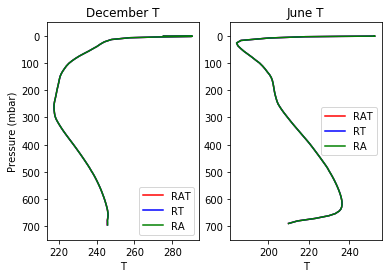

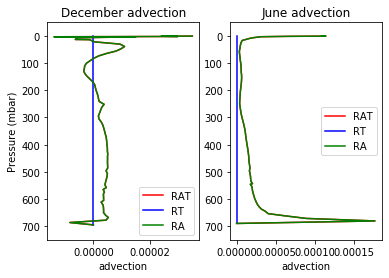

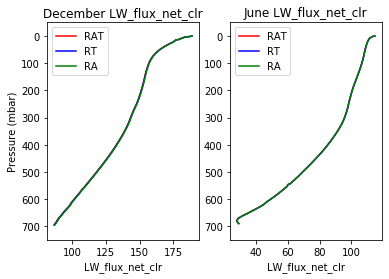

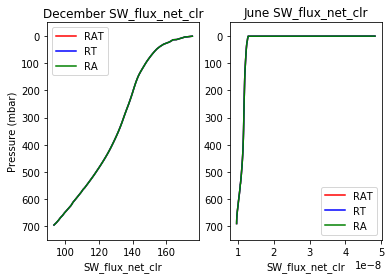

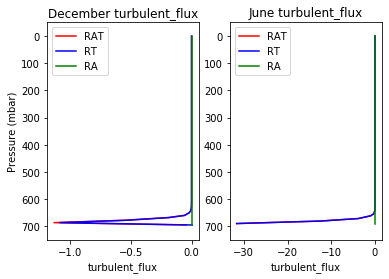

In [250]:
time = time7
for output in ['T','advection', 'LW_flux_net_clr', 'SW_flux_net_clr', 'turbulent_flux']:
    fig, axes = plt.subplots(1, 2)
    for idx, month in enumerate([month1, month2]):
        ax = axes[idx]
        ax.plot(month_ds_dict[month].sel(co2_lev = .00038, model = 'rat', time = time)[output],
                month_ds_dict[month].sel(co2_lev = .00038, model = 'rat', time = time)['lev_full'], 
                color = 'r',
                label = 'RAT'
               )
        ax.plot(month_ds_dict[month].sel(co2_lev = .00038, model = 'rt', time = time)[output],
                month_ds_dict[month].sel(co2_lev = .00038, model = 'rt', time = time)['lev_full'], 
                color = 'b',
                label = 'RT')
        ax.plot(month_ds_dict[month].sel(co2_lev = .00038, model = 'ra', time = time)[output],
                month_ds_dict[month].sel(co2_lev = .00038, model = 'ra', time = time)['lev_full'], 
                color = 'g',
                label = 'RA')
        ax.legend()
        ax.set_xlabel(output)
        axes[0].set_ylabel('Pressure (mbar)')
        ax.set_ylim([750,-50])
        ax.set_title(month + ' ' + output)

### find entire column energy balance

In [303]:
#time we're looking at
time = time6-3600
month = month1
co2 = 0.00038

In [306]:
for model in ['ra','rat','rt']:
    #TOA Frad
    F_rad_toa =np.asarray(month_ds_dict[month]['SW_flux_net_clr'].sel(co2_lev = co2, time = time, model = model)[0]) - np.asarray(month_ds_dict[month]['LW_flux_net_clr'].sel(co2_lev = co2, time = time, model = model)[0]) #W/m2

    #Surface Frad
    F_rad_sfc = np.asarray(month_ds_dict[month]['SW_flux_net_clr'].sel(co2_lev = co2, time = time, model = model)[-1]) - np.asarray(month_ds_dict[month]['LW_flux_net_clr'].sel(co2_lev = co2, time = time, model = model)[-1]) #W/m2

    #Surface Fturb
    F_turb_sfc = np.asarray(month_ds_dict[month]['turbulent_flux'].sel(co2_lev = co2, time = time, model = model)[-1]) #W/m2

    F_sfc = F_rad_sfc - F_turb_sfc
    #dT/dt
    total_atm_hr = ((np.asarray(month_ds_dict[month]['T'].sel(co2_lev = co2, time = time+timestep, model = model)) - 
                    np.asarray(month_ds_dict[month]['T'].sel(co2_lev = co2, time = time, model = model)))[:-1]/np.asarray(timestep)) #K/s

    #dz
    delta_z = -np.diff(month_ds_dict[month]['z_bounds']) #surface to atmosphere #m

    #heat capacity (density*cp)
    R = 8.314 #J/mol/K
    MW_air = 0.0289647 #kg/mol
    pressure_TOA = 100*month_ds_dict[month]['lev'][-1] #pascal (kg/m/s2)
    density_atm = (MW_air*100*month_ds_dict[month]['lev'])/(np.asarray(month_ds_dict[month]['T'].sel(co2_lev = co2, time = time+timestep, model = model)[:-1]) * R) #kg/m^3
    cp_air = 1003 #specific heat of air (at 250 K) J/(kg*K)
    heat_capacity_atm = density_atm*cp_air

    #atmospheric heat content rate at each level
    total_atm_heat_content_rate = total_atm_hr * heat_capacity_atm * delta_z #W/m2

    #advective flux at each level
    total_adv_flux = -np.asarray(month_ds_dict[month]['advection'].sel(co2_lev = co2, time = time, model = model)[:-1]) * heat_capacity_atm * delta_z #W/m2

    energy_budget = {}
    energy_budget[month] = F_rad_toa - F_sfc - total_adv_flux.sum().values - total_atm_heat_content_rate.sum().values
    print(f'{model} W/m^2: ',
         '\nTOA Radiative Flux ' + str(F_rad_toa), 
          '\nSFC Radiative Flux ' + str(F_rad_sfc), 
          '\nSFC Turbulent Flux ' + str(F_turb_sfc), 
          '\nAtmospheric heat content flux ' + str(total_atm_heat_content_rate.sum().values),
          '\nAtmospheric advective flux ' + str(total_adv_flux.sum().values),
         '\nEnergy Budget ' +str(energy_budget),
         '\n ')


ra W/m^2:  
TOA Radiative Flux -13.64119662623574 
SFC Radiative Flux 6.215115517580131 
SFC Turbulent Flux 0.0 
Atmospheric heat content flux 0.6110725715175587 
Atmospheric advective flux -20.275646198699697 
Energy Budget {'December': -0.1917385166337322} 
 
rat W/m^2:  
TOA Radiative Flux -13.275548498270723 
SFC Radiative Flux 6.745479776191914 
SFC Turbulent Flux -0.05403995352965767 
Atmospheric heat content flux 0.3273945120873031 
Atmospheric advective flux -20.275716660566815 
Energy Budget {'December': -0.12674607951278183} 
 
rt W/m^2:  
TOA Radiative Flux -13.461614403626811 
SFC Radiative Flux 6.469079942742766 
SFC Turbulent Flux 0.0011266527364094516 
Atmospheric heat content flux 0.4903748241691004 
Atmospheric advective flux 0.0 
Energy Budget {'December': -20.41994251780227} 
 


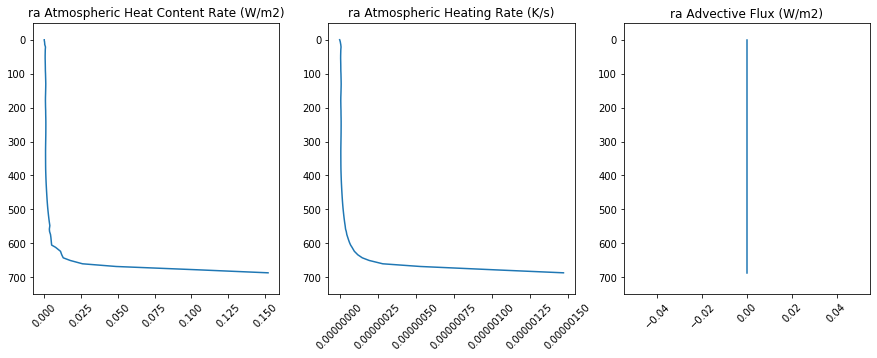

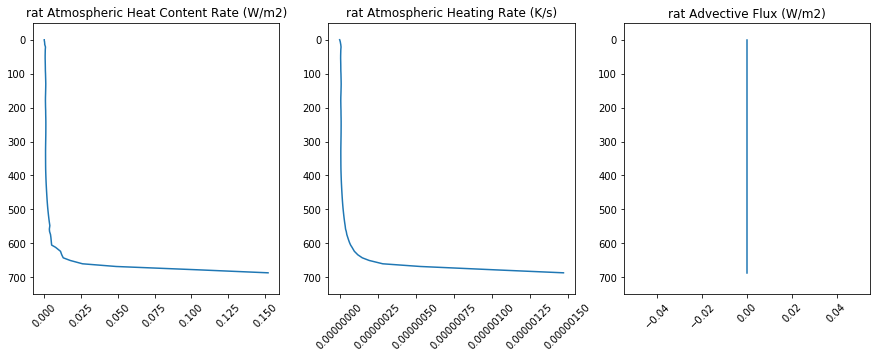

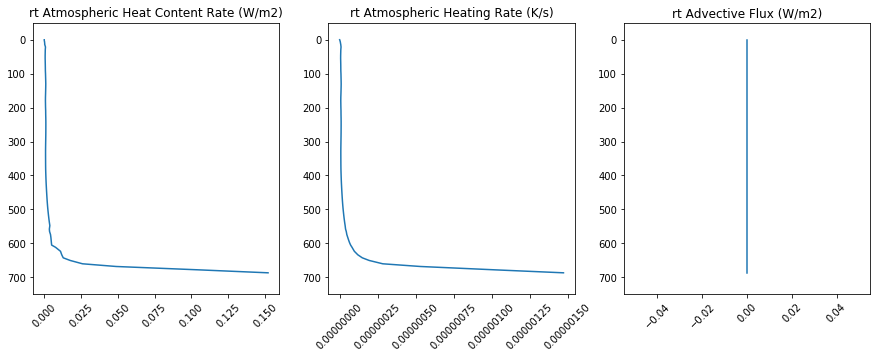

In [307]:
for model in ['ra','rat','rt']:

    fig, axes = plt.subplots(1,3, figsize = (15,5))
    for idx, output in enumerate([total_atm_heat_content_rate, total_atm_hr, total_adv_flux]):
        ax = axes[idx]
        ax.plot(output, month_ds_dict[month]['lev'])
        ax.set_ylim([750,-50])
        ax.tick_params(axis='x', labelrotation= 45) 
    axes[0].set_title(f'{model} Atmospheric Heat Content Rate (W/m2)')
    axes[1].set_title(f'{model} Atmospheric Heating Rate (K/s)')
    axes[2].set_title(f'{model} Advective Flux (W/m2)')

#### alternative energy budget with surface

In [305]:
for model in ['ra','rat','rt']:

    #dTatm/dt
    total_atm_hr = ((np.asarray(month_ds_dict[month]['T'].sel(co2_lev = co2, time = time+timestep, model = model)[:-1])) - np.asarray(month_ds_dict[month]['T'].sel(co2_lev = co2, time = time, model = model)[:-1]))/np.asarray(timestep) #K/s

    #dTs/dt
    total_sfc_hr = ((np.asarray(month_ds_dict[month]['T'].sel(co2_lev = co2, time = time+timestep, model = model)[-1])) - np.asarray(month_ds_dict[month]['T'].sel(co2_lev = co2, time = time, model = model)[-1]))/np.asarray(timestep) #K/s

    #dz
    delta_z = np.diff(np.asarray(month_ds_dict[month]['z_bounds'])) #surface to atmosphere #m

    #heat capacity (density*cp)
    R = 8.314 #J/mol/K
    MW_air = 0.0289647 #kg/mol
    pressure_TOA = 100*np.asarray(month_ds_dict[month]['lev'][-1]) #pascal (kg/m/s2)
    density_atm = (MW_air*100*month_ds_dict[month]['lev'])/(np.asarray(month_ds_dict[month]['T'].sel(co2_lev = co2, time = time, model = model)[:-1]) * R) #kg/m^3
    cp_air = 1003 #specific heat of air (at 250 K) J/(kg*K)
    heat_capacity_atm = density_atm*cp_air
    dz_ground = 1
    heat_capacity_sfc = climlab.utils.heat_capacity.ocean(dz_ground)

    #atmospheric heat content rate at each level
    total_atm_heat_content_rate = total_atm_hr * heat_capacity_atm * delta_z #W/m2

    #surface heat content rate
    total_surface_heat_content_rate = total_sfc_hr * heat_capacity_sfc * dz_ground

    #advective flux at each level
    total_adv_flux = np.asarray(month_ds_dict[month]['advection'].sel(co2_lev = co2, time = time, model = model)[:-1]) * heat_capacity_atm * delta_z #W/m2

    energy_budget = {}
    energy_budget[month] = F_rad_toa - total_adv_flux.sum().values - total_atm_heat_content_rate.sum().values - total_surface_heat_content_rate.sum()
    print(f'{model} W/m^2: ',
         '\nTOA Radiative Flux ' + str(F_rad_toa), 
          '\nAtmospheric heat content flux ' + str(total_atm_heat_content_rate.sum().values),
          '\nAtmospheric advective flux ' + str(total_adv_flux.sum().values),
          '\nSurface heat content flux ' + str(total_surface_heat_content_rate.sum()),
         '\nEnergy Budget ' +str(energy_budget),
         '\n ')



ra W/m^2:  
TOA Radiative Flux -13.461614403626811 
Atmospheric heat content flux -0.6110788800463605 
Atmospheric advective flux -20.275655797690263 
Surface heat content flux 6.170783269923647 
Energy Budget {'December': 1.2543370041861648} 
 
rat W/m^2:  
TOA Radiative Flux -13.461614403626811 
Atmospheric heat content flux -0.3273986420438884 
Atmospheric advective flux -20.275708772916182 
Surface heat content flux 6.780927102947057 
Energy Budget {'December': 0.36056590838620295} 
 
rt W/m^2:  
TOA Radiative Flux -13.461614403626811 
Atmospheric heat content flux -0.49038033381612023 
Atmospheric advective flux 0.0 
Surface heat content flux 6.452905992158884 
Energy Budget {'December': -19.424140061969574} 
 


#### TOA Energy budget

In [139]:
TOA_budget = F_rad_toa - total_adv_flux.sum()

print(month, 'dif between OLR and ASR+Advection', TOA_budget)

December dif between OLR and ASR+Advection <xarray.DataArray 'lev' ()>
array(6.98125116)


#### surface energy budget

In [140]:
sfc_budget = total_surface_heat_content_rate - F_sfc
print(month, 'dif between surface heat content and surface flux', sfc_budget)

December dif between surface heat content and surface flux -0.018008262331510316


#### sum the TOA and surface budgets

In [141]:
TOA_budget + sfc_budget

<xarray.DataArray 'lev' ()>
array(6.9632429)

#### calculate total surface heating rate

In [51]:
heat_capacity_sfc = climlab.utils.heat_capacity.ocean(1)
rad_sfc_HR = {}
for time in results_dict.keys():
    rad_sfc_HR[time] = {}
    for CO2_conc in results_dict[0]['turb_sfc_hr'].keys():
        rad_sfc_HR[time][CO2_conc] = {}
        for month in results_dict[0]['turb_sfc_hr'][0.00038].keys():
            rad_sfc_HR[time][CO2_conc][month] = {}
            F_rad_sfc = np.asarray(results_dict[time]['LW_sfc_clr'][CO2_conc][month]) - np.asarray(results_dict[time]['SW_sfc_clr'][CO2_conc][month]) #W/m2
            rad_sfc_HR[time][CO2_conc][month] = F_rad_sfc / heat_capacity_sfc

#### solar insolation

#### absorption coefficients and pressure

In [215]:
# estimate the absorption coefficient for CO2 = 1e-4 m2/kg
# P*CO2 mixing ratio * absorption coefficient / g = 1
# so g/CO2 mixing ratio /absorption coefficient = P

g = 9.8 #m/s2
mmr = 200*1e-6#ppm
abs_coef = 1

P = g/(mmr*abs_coef) #kg*s2/ m
P/100

490.00000000000006

In [207]:
wl = 15 #um
wn = 1/wl * 1e4
wn

666.6666666666666

#### standard atmosphere vs antarctic

In [259]:
#### compare between our antarctic version and a normal atmosphere
alb = 0.25
#  State variables (Air and surface temperature)
state = climlab.column_state(num_lev=30)
#  Parent model process
rcm = climlab.TimeDependentProcess(state=state)
#  Fixed relative humidity
h2o = climlab.radiation.ManabeWaterVapor(state=state)
#  Couple water vapor to radiation
rad = climlab.radiation.RRTMG(state=state, specific_humidity=h2o.q, albedo=alb)
#  Convective adjustment
conv = climlab.convection.ConvectiveAdjustment(state=state, adj_lapse_rate=6.5)
#  Couple everything together
rcm.add_subprocess('Radiation', rad)
rcm.add_subprocess('WaterVapor', h2o)
rcm.add_subprocess('Convection', conv)
#  Run the model
rcm.integrate_years(1)


Opened data from /opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 0.9993368783782377 years.


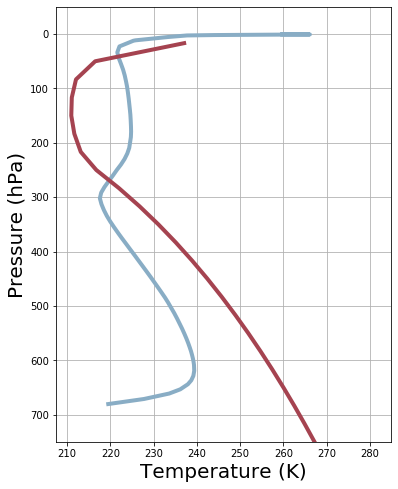

In [263]:
fig, ax = plt.subplots(figsize = [6,8])
colors=cm.twilight(np.linspace(0,1,8))
for month in ['March']:
    #plot our antarctic atmosphere
    x = np.asarray(results_dict[0]['Tatm'][0.00038][month])
    y = results_dict[0]['lev'][0.00038][month]
    plt.plot(x, y, c = colors[1], lw = 4)
    
    #plot standard atmosphere
    plt.plot(rcm.state['Tatm'], rcm.lev, c= colors[5], lw = 4)
    
    #labels and lims
    plt.ylabel('Pressure (hPa)', fontsize = 20)
    plt.xlabel('Temperature (K)', fontsize = 20)
    plt.ylim([750,-50])
plt.grid()
plt.savefig('../figures/stp_antarctic_comp.png', dpi = 150, bbox_inches = 'tight')

In [ ]:
for month in months:
    for co2 in co2_lev:
        for time in np.arange(0,((steps+1)*timestep),timestep):
            for model in model_dict.keys():
                
                #TOA Frad
                month_ds_dict[month]['F_rad_toa'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = np.asarray(month_ds_dict[month]['SW_flux_net_clr'].sel(co2_lev = co2, time = time, model = model)[0]) - np.asarray(month_ds_dict[month]['LW_flux_net_clr'].sel(co2_lev = co2, time = time, model = model)[0]) #W/m2

                #Surface Frad
                month_ds_dict[month]['F_rad_sfc'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = np.asarray(month_ds_dict[month]['SW_flux_net_clr'].sel(co2_lev = co2, time = time, model = model)[-1]) - np.asarray(month_ds_dict[month]['LW_flux_net_clr'].sel(co2_lev = co2, time = time, model = model)[-1]) #W/m2

                #Surface Fturb
                month_ds_dict[month]['F_turb_sfc'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = np.asarray(month_ds_dict[month]['turbulent_flux'].sel(co2_lev = co2, time = time, model = model)[-1]) #W/m2

                month_ds_dict[month]['F_sfc'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = model_dict[model][F_rad_sfc].loc[dict(co2_lev = co2, time = time, model = dict_name)] - model_dict[model][F_turb_sfc].loc[dict(co2_lev = co2, time = time, model = dict_name)]
                #dT/dt
                month_ds_dict[month]['total_atm_hr'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = ((np.asarray(month_ds_dict[month]['T'].sel(co2_lev = co2, time = time+timestep, model = model)) - 
                                np.asarray(month_ds_dict[month]['T'].sel(co2_lev = co2, time = time, model = model)))[:-1]/np.asarray(timestep)) #K/s

                #dz
                month_ds_dict[month]['delta_z'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = np.diff(month_ds_dict[month]['z_bounds']) #surface to atmosphere #m

                #heat capacity (density*cp)
                month_ds_dict[month]['R'] = 8.314 #J/mol/K
                month_ds_dict[month]['MW_air'] = 0.0289647 #kg/mol
                month_ds_dict[month]['pressure_TOA'] = 100*month_ds_dict[month]['lev'][-1] #pascal (kg/m/s2)
                month_ds_dict[month]['density_atm'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = (month_ds_dict[month]['MW_air']*100*month_ds_dict[month]['lev'])/(np.asarray(month_ds_dict[month]['T'].sel(co2_lev = co2, time = time, model = model)[:-1]) * month_ds_dict[month]['R']) #kg/m^3
                month_ds_dict[month]['cp_air'] = 1003 #specific heat of air (at 250 K) J/(kg*K)
                month_ds_dict[month]['heat_capacity_atm'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = month_ds_dict[month]['density_atm'].loc[dict(co2_lev = co2, time = time, model = dict_name)]*month_ds_dict[month]['cp_air']

                #atmospheric heat content rate at each level
                month_ds_dict[month]['total_atm_heat_content_rate'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = month_ds_dict[month]['total_atm_hr'].loc[dict(co2_lev = co2, time = time, model = dict_name)] * month_ds_dict[month]['heat_capacity_atm'].loc[dict(co2_lev = co2, time = time, model = dict_name)] * month_ds_dict[month]['delta_z'].loc[dict(co2_lev = co2, time = time, model = dict_name)] #W/m2

                #advective flux at each level
                month_ds_dict[month]['total_adv_flux'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = np.asarray(month_ds_dict[month]['advection'].sel(co2_lev = co2, time = time, model = model)[:-1]) * month_ds_dict[month]['heat_capacity_atm'].loc[dict(co2_lev = co2, time = time, model = dict_name)] * month_ds_dict[month]['delta_z'].loc[dict(co2_lev = co2, time = time, model = dict_name)] #W/m2
                
                